In [1]:
import sys
# sys.path.append('../')
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import numpy as np
import matplotlib.pyplot as plt
plt.rc('text',usetex=True)
plt.rc('font',family='serif')

from pylab import *
import pickle
from math import log
from torch.nn import parameter

import torch 
import torch.nn as nn

if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

from fracturbulence.common import *
from fracturbulence.Calibration import CalibrationProblem
from fracturbulence.DataGenerator import OnePointSpectraDataGenerator

import constants.consts_exp1 as consts_exp1

from time import time

from pathlib import Path

savedir = Path().resolve() / "data" / "results" 

In [2]:
import fracturbulence as ft

In [3]:
config = {
    'type_EddyLifetime' :   'tauNet', #'TwoThird', #'tauNet', # CALIBRATION : 'tauNet',  ### 'const', TwoThird', 'Mann', 'tauNet'
    'type_PowerSpectra' :   'RDT', ### 'RDT', 'zetaNet', 'C3Net', 'Corrector'
    'nlayers'           :   2,
    'activations': [nn.ReLU(), nn.ReLU()],
    'hlayers' : [10, 10], 
    #'hidden_layer_size' :   10,
    # 'nModes'            :   5, ### number of modes in the rational function in tauNet ### deprecated
    'learn_nu'          :   False, ### NOTE: Experiment 1: False, Experiment 2: True
    'plt_tau'           :   True,
    'plot_loss_wolfe'   :   True, 
    'tol'               :   1.e-3, ### not important
    'lr'                :   1,     ### learning rate
    'penalty'           :   1, # CALIBRATION: 1.e-1,
    'regularization'    :   1.e-5,# CALIBRATION: 1.e-1,
    'nepochs'           :   10,
    'curves'            :   [0,1,2,3],
    'data_type'         :   'Kaimal',  # CALIBRATION: 'Custom', ### 'Kaimal', 'SimiuScanlan', 'SimiuYeo', 'iso'
    'spectra_file'      :   'Spectra.dat',
    'Uref'              :   10, # m/s
    'zref'              :   1, #m
    'domain'            :   torch.logspace(-1, 2, 20), #np.logspace(-4, 2, 40), ### NOTE: Experiment 1: np.logspace(-1, 2, 20), Experiment 2: np.logspace(-2, 2, 40)
    'noisy_data'        :   0.,#0*3.e-1, ### level of the data noise  ### NOTE: Experiment 1: zero, Experiment 2: non-zero
    'output_folder'     :   str(savedir), 
    'input_folder'     :   '/Users/gdeskos/work_in_progress/WindGenerator/script/'
}


[ReLU(), ReLU()]
DataValues is on 0


/home/ai/miniconda3/envs/fracturbulence/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[format_output] -- HERE!

Calibrating MannNet...
torch.Size([80])
Initial loss:  0.09343572565775507

[Calibration.py -- calibrate]-> Epoch 0

loss  =  0.09351752419298763
loss  =  0.7691735892662102
loss  =  0.03753761778255037
loss  =  0.037442823703228996
loss  =  0.03702632418044109
loss  =  0.03696093746754033
loss  =  0.03674139663200093
loss  =  0.03654625693918322
loss  =  0.036365790879793844
loss  =  0.035957314213864645
loss  =  0.035287430314324755
loss  =  0.03312080645910805
loss  =  0.03283406827663301
loss  =  0.032525460697940774
loss  =  0.031966730789329004
loss  =  0.03295447436612169
loss  =  0.02953352335249462
loss  =  0.18307783781765888
loss  =  0.034524447542271505
loss  =  0.028422945212582238
loss  =  0.02864876313205881
loss  =  0.02330160787797641
loss  =  0.02244097027322875
loss  =  0.02226948662518391
loss  =  0.021689889489674062
---------------------------------



[Calibration.py -- calibrate]-> Epoch 1



/home/ai/miniconda3/envs/fracturbulence/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


loss  =  0.021689889489674062
loss  =  0.02124995038354005
loss  =  0.02117673977038012
loss  =  0.021143813730658986
loss  =  0.021123919187208115
loss  =  0.021097557623320228
loss  =  0.02107239164533782
loss  =  0.020998913545550793
loss  =  0.02089491034520617
loss  =  0.02058480310148989
loss  =  0.020467916165372885
loss  =  0.02017341178133056
loss  =  0.020319024134511973
loss  =  0.02007050026738249
loss  =  0.0200159605595159
loss  =  0.0199884297067469
loss  =  0.019896288134635662
loss  =  0.01991189629402721
loss  =  0.01981530073458751
loss  =  0.019642371404211264
loss  =  0.0194310730971147
loss  =  0.019335120649759948
loss  =  0.019957071768758855
loss  =  0.01913822047012581
loss  =  0.059382099630964434
loss  =  0.01911838767619222
---------------------------------



[Calibration.py -- calibrate]-> Epoch 2

loss  =  0.01911838767619222
loss  =  0.02058691121431822
loss  =  0.01904826356671377
loss  =  0.019023897882103905
loss  =  0.01894421817907379
loss  =  0.01

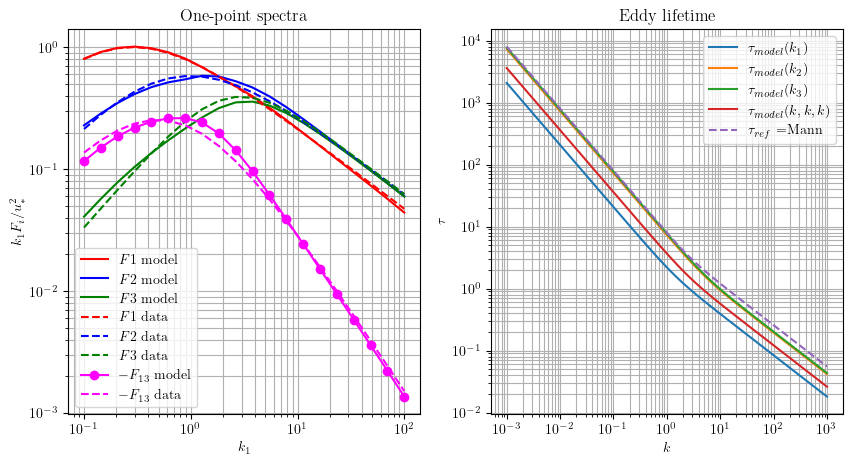

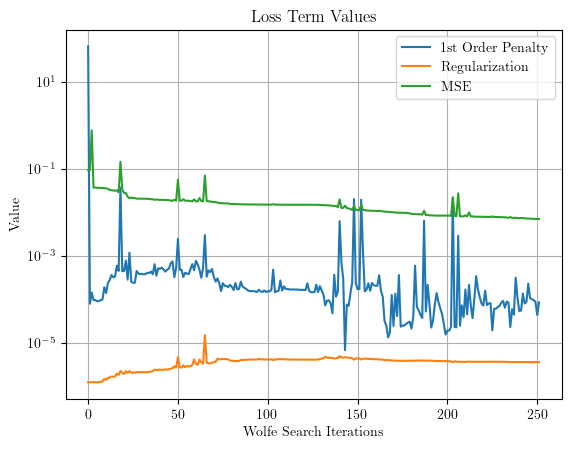

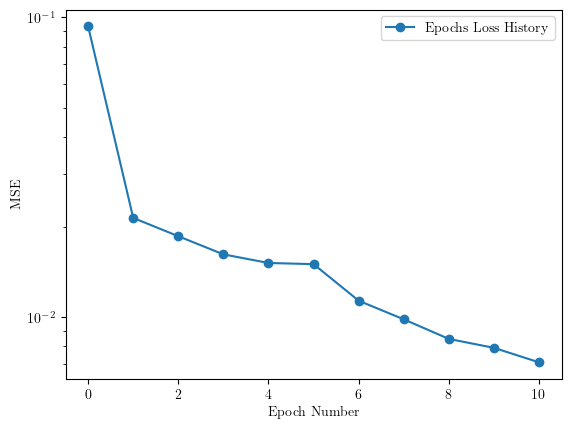

In [4]:
start = time() 

pb = CalibrationProblem(**config)
parameters = pb.parameters
parameters[:3] = [log(consts_exp1.L), log(consts_exp1.Gamma), log(consts_exp1.sigma)] #All of these parameters are positive 
    #so we can train the NN for the log of these parameters. 
pb.parameters = parameters[:len(pb.parameters)]
k1_data_pts = config['domain'] #np.logspace(-1, 2, 20)
DataPoints  = [ (k1, 1) for k1 in k1_data_pts ]
Data = OnePointSpectraDataGenerator(DataPoints=DataPoints, **config).Data

DataValues = Data[1]

IECtau=MannEddyLifetime(k1_data_pts*consts_exp1.L)
kF = pb.eval(k1_data_pts)

opt_params = pb.calibrate(Data=Data, **config)#, OptimizerClass=torch.optim.RMSprop)

plt.figure()

        #plt.plot( pb.loss_history_total, label="Total Loss History")
plt.plot( pb.loss_history_epochs, 'o-', label="Epochs Loss History")
plt.legend() 
plt.xlabel("Epoch Number")
plt.ylabel("MSE")
plt.yscale('log')

plt.show() 


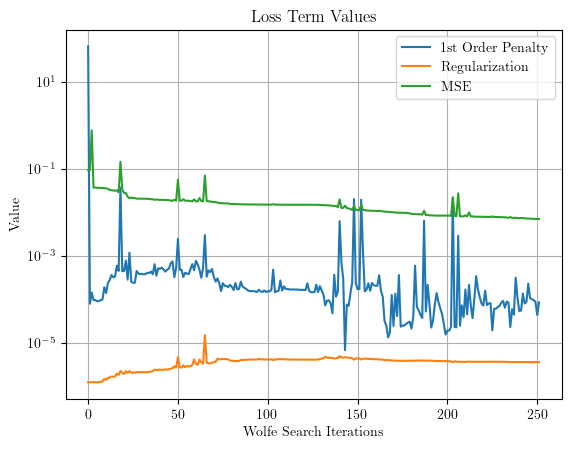

In [5]:
plt.figure()
plt.plot(pb.loss_2ndOpen, label="1st Order Penalty")
plt.plot(pb.loss_reg,  label="Regularization")
plt.plot(pb.loss_history_total, label="MSE")

plt.title("Loss Term Values")

plt.ylabel("Value")
plt.xlabel("Wolfe Search Iterations")
plt.yscale('log')
plt.legend()
plt.grid('true')
plt.show()
